# IMPORTS

In [1]:
import tensorflow as tf
import datetime
import time
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import os
import generate_labels_text_file
from collections import Counter
from random import shuffle, randint, seed
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.framework import graph_util
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
%matplotlib inline

100%|██████████| 135/135 [00:00<?, ?it/s]


In [2]:
print(f'OpenCV version: {cv2.__version__}')
print(f'Tensorflow version: {tf.__version__}')

OpenCV version: 4.1.1
Tensorflow version: 2.0.0


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# PREPROCESSING

In [4]:
# Check what folder to use for training and testing images
# CHISOM_TRAIN_DIR = 'C:/Users/chiso/MEGA/data/train'
#CHISOM_TEST_DIR = 'C:/Users/chiso/MEGA/data/test'
CHISOM_ALIGNED_TRAIN_DIR = 'C:/Users/chiso/MEGA/data/aligned_train'
CHISOM_ALIGNED_TEST_DIR = 'C:/Users/chiso/MEGA/data/aligned_test'

# YISI_TRAIN_DIR = 'E:/MegaSync/data/train'
#YISI_TEST_DIR = 'E:/MegaSync/data/test'
YISI_ALIGNED_TRAIN_DIR = 'E:/MegaSync/data/aligned_train'
YISI_ALIGNED_TEST_DIR = 'E:/MegaSync/data/aligned_test'


def get_directories():
    if os.path.exists(CHISOM_ALIGNED_TRAIN_DIR) and os.path.exists(CHISOM_ALIGNED_TEST_DIR):
        return CHISOM_ALIGNED_TRAIN_DIR, CHISOM_ALIGNED_TEST_DIR
    else:
        return YISI_ALIGNED_TRAIN_DIR, YISI_ALIGNED_TEST_DIR


### Useful Parameters

In [5]:
DATE = datetime.datetime.now().strftime('%d-%b-%Y')
ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR = get_directories()
IMG_SIZE = 100
LR = 1e-3
MODEL_PATH = f'models/{DATE}/'
MODEL_NAME = 'ImageClassifier-keras-5-Conv-Layer-{}.model'.format(int(time.time()))
TENSORBOARD = TensorBoard(log_dir=f'logs\\{MODEL_NAME}') 
NUM_CLASSES = len(next(os.walk(ALIGNED_TRAIN_DIR))[1])
NUM_CLASSES, IMG_SIZE

(135, 100)

In [6]:
ALIGNED_TRAIN_DIR, ALIGNED_TEST_DIR

('C:/Users/chiso/MEGA/data/aligned_train',
 'C:/Users/chiso/MEGA/data/aligned_test')

### Walkthrough of Subfolders in Train Directory:

In [7]:
# Only the root
ROOTS = next(os.walk(ALIGNED_TRAIN_DIR))[0]
print(f"Roots = {ROOTS}")

Roots = C:/Users/chiso/MEGA/data/aligned_train


In [8]:
# Only the directories
DIRS = next(os.walk(ALIGNED_TRAIN_DIR))[1]
DIRS

['Abella Danger',
 'Abigail Mac',
 'Agatha Vega',
 'Aiden Starr',
 'Aidra Fox',
 'Aletta Ocean',
 'Alina Li',
 'Alina Lopez',
 'Allie Haze',
 'Ally Milano',
 'Amirah Adara',
 'Ana Rose',
 'Andriana Chechik',
 'Angel Princess',
 'Angela Sommers',
 'Anita Dark',
 'Ariella Ferrera',
 'Audrey Bitoni',
 'Ava Addams',
 'Bella Milano',
 'Blake Bartelli',
 'Bobbi Star',
 'Brandi Love',
 'Bree Daniels',
 'Brenda James',
 'Bridgette B',
 'Cameron Canela',
 'Cassidy Klein',
 'Catarina Petrov',
 'Chastity Lynn',
 'Cherie De Ville',
 'Christy Mack',
 'Dana DeArmond',
 'Dana Weyron',
 'Dani Daniels',
 'Deauxma',
 'Dia Zerva',
 'Diana Ladonna',
 'Elexis Monroe',
 'Emily Willis',
 'Emma Hix',
 'Eva Notty',
 'Evelina Darling',
 'Evelyn Lin',
 'Gianna Dior',
 'India Summer',
 'Isabelle Deltore',
 'Janet Mason',
 'Jelena Jensen',
 'Jenna Sativa',
 'Jessa Rhodes',
 'Jessica Bangkok',
 'Jodie Taylor',
 'Julia Ann',
 'Karlie Montana',
 'Karter Foxx',
 'Kate Rich',
 'Katie A Delicia',
 'Kayla Kayden',
 'Kimm

In [9]:
# Only the files
"""for root, dirs, files in os.walk(ALIGNED_TRAIN_DIR):
    for name in files:
        print(name.split('.')[0]) # filters the file name by file extension and the copy_number
        
"""

"for root, dirs, files in os.walk(ALIGNED_TRAIN_DIR):\n    for name in files:\n        print(name.split('.')[0]) # filters the file name by file extension and the copy_number\n        \n"

### One-Hot Encoding

In [10]:
LABELS = next(os.walk(ALIGNED_TRAIN_DIR))[1] # all the class labels (pornstar names) to be used
LABELS = np.reshape(LABELS, (-1, 1)) # reshapes array from 1D to 2D array
mlb = MultiLabelBinarizer()
encoded_labels = np.array(mlb.fit_transform(LABELS))
# dict(zip(LABELS.flatten(), encoded_labels))

In [11]:
# img.split('.')[0].split('(')[0]  # filters the file name by file extension and the copy_number
"""
Labelled training data
"""
def create_train_data():
    training_data = []
    # iterate over each image-class (subfolder) in training directory
    for folder in tqdm(os.listdir(ALIGNED_TRAIN_DIR)):
        full_path = f'{ALIGNED_TRAIN_DIR}/{folder}'
        # iterate over each image in each subfolder
        for img in os.listdir(full_path):
            ##### !python align_images.py raw_images/ aligned_images/ --output_size=1048
            img_name = str(folder)  # the sub-folder is used as the image name for each image
            img_name = img_name.strip() # removes any leading and trailing whitespaces from the img name
            label = mlb.transform([[img_name]]) # encodes the label of the image using MultiLabelBinarizer
            label = label.flatten()  # converts encoded label from 2D to 1D array
            # print(f'Image: {img} - Encoding:{label}')
            path = os.path.join(full_path, img)  # full path of the image
            # feature extraction
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            img = tf.cast(img, tf.float32) # change data type of image to float32
            training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [12]:
"""
Unlabelled test data
"""
def process_test_data():
    img_ids = list(range(len(os.listdir(ALIGNED_TEST_DIR)))) # generates list of ID numbers
    shuffle(img_ids) # randomly assorted
    img_ids = iter(img_ids) 
    testing_data = [] 
    for img in tqdm(os.listdir(ALIGNED_TEST_DIR)):
        path = os.path.join(ALIGNED_TEST_DIR, img)
        img_num = next(img_ids)
        print(f"ID: {img_num} \t- Image: {img}")
        # feature extraction
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32)
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data     

### Generate Training and Testing data

In [13]:
train_data = create_train_data()
test_data = process_test_data()
# if train/test data already exists
# train_data = np.load('train_data.npy', allow_pickle=True)
# test_data = np.load('test_data.npy', allow_pickle=True)

100%|██████████| 44/44 [00:01<00:00, 30.51it/s]


ID: 25 	- Image: Aiden Starr.png
ID: 34 	- Image: Allie Haze.png
ID: 26 	- Image: Andriana Chechik.png
ID: 31 	- Image: Anita Dark.png
ID: 10 	- Image: Ariella Ferrera.png
ID: 40 	- Image: Blake Bartelli.png
ID: 37 	- Image: Bridgette B.png
ID: 18 	- Image: Catarina Petrov.png
ID: 43 	- Image: Cherie De Ville.png
ID: 12 	- Image: Dana DeArmond.png
ID: 24 	- Image: Deauxma.png
ID: 19 	- Image: Emily Willis.png
ID: 33 	- Image: Evelina Darling.png
ID: 0 	- Image: Gianna Dior.png
ID: 15 	- Image: Isabelle Deltore.png
ID: 27 	- Image: Jenna Sativa.png
ID: 28 	- Image: Jessa Rhodes.png
ID: 20 	- Image: Jessica Bangkok.png
ID: 39 	- Image: Julia Ann.png
ID: 35 	- Image: Kristen Scott.png
ID: 41 	- Image: Krystal Boyd.png
ID: 8 	- Image: Lana Rhoades.png
ID: 5 	- Image: Lisa Ann.png
ID: 29 	- Image: Madison Ivy.png
ID: 36 	- Image: Marcelin Abadir.png
ID: 2 	- Image: Mellanie Monroe.png
ID: 21 	- Image: Mia Khalifa.png
ID: 4 	- Image: Misty Stone.png
ID: 32 	- Image: Nicole Aniston.png
ID: 6 

In [14]:
print(len(train_data))
print(len(test_data))

12104
44


# BUILDING THE MODEL

### Implementation of Convoluted Neural Network

In [15]:
def create_cnn_model():
    # tf.reset_default_graph()
    model = Sequential()
    input_shape = (IMG_SIZE, IMG_SIZE, 1)
    
    # INPUT LAYER
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # HIDDEN LAYER 1
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # HIDDEN LAYER 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))
    
    # HIDDEN LAYER 4
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.25))

    # Fully Connected
    model.add(Flatten()) # converts the 3D feature maps to 1D feature vectors
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.25)) # reduces overfitting

    # OUTPUT LAYER
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# TRAINING THE NETWORK

### Cross Validation Train/Test Split

In [16]:
ratio = int(round(len(train_data), -1) * 0.2)
ratio

2420

In [17]:
train = train_data[:-ratio] # sample train data
test = train_data[-ratio:]

In [18]:
train_X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # train features (images)
train_Y = np.array([i[1] for i in train]) # train labels

test_X = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # test features (images)
test_Y = np.array([i[1] for i in test]) # test labels

### Feature Scaling (Normalization)

In [19]:
# Have to divide by 255 
train_X = train_X/255.0
test_X = test_X/255.0

In [20]:
print(f"train data: {train_X.shape}")
print(f"train labels: {train_Y.shape}")
print(f"test data: {test_X.shape}")
print(f"test labels: {test_Y.shape}")

train data: (9684, 100, 100, 1)
train labels: (9684, 135)
test data: (2420, 100, 100, 1)
test labels: (2420, 135)


### Frequency distribution of classes being used in "test data"

In [21]:
enc = []
for img in test:
    enc.append(img[1])
    
enc = np.array(enc)
test_labels = mlb.inverse_transform(enc)
c = Counter(test_labels)
c

Counter({('Mila Azul',): 32,
         ('Abigail Mac',): 23,
         ('Audrey Bitoni',): 26,
         ('Rachel Starr',): 11,
         ('Nicole Aniston',): 27,
         ('Blake Bartelli',): 13,
         ('Ava Addams',): 20,
         ('Karter Foxx',): 22,
         ('Lisa Ann',): 29,
         ('Cameron Canela',): 13,
         ('Leyla Fiore',): 9,
         ('Miranda Deen',): 36,
         ('Bree Daniels',): 23,
         ('Lea Guerlin',): 19,
         ('Rachele Richey',): 24,
         ('Bridgette B',): 20,
         ('Susana Spears',): 20,
         ('Paige Owens',): 15,
         ('Andriana Chechik',): 19,
         ('Janet Mason',): 25,
         ('Jelena Jensen',): 21,
         ('Shyla Jennings',): 15,
         ('Sydney Cole',): 21,
         ('Aletta Ocean',): 10,
         ('Emily Willis',): 21,
         ('Sofy Soul',): 29,
         ('Deauxma',): 22,
         ('Susy Gala',): 11,
         ('Lizzie Ryan',): 24,
         ('Riley Reid',): 23,
         ('Christy Mack',): 17,
         ('Penelope Y S

In [22]:
MODEL = create_cnn_model()
MODEL.summary()
history = MODEL.fit(train_X, train_Y, batch_size=32, epochs=100, validation_data=(test_X, test_Y), verbose=2, callbacks=[TENSORBOARD])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        1

## Saving Model

In [23]:
MODEL.save(f'{MODEL_PATH}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/06-Dec-2019/assets


## Load Model

In [24]:
"""date = datetime.date(2019, 11, 6).strftime('%d-%b-%Y')
model_path = f'models/{date}/'
MODEL = tf.keras.models.load_model(f'{model_path}')"""
# MODEL =  tf.keras.models.load_model(f'{MODEL_PATH}')

"date = datetime.date(2019, 11, 6).strftime('%d-%b-%Y')\nmodel_path = f'models/{date}/'\nMODEL = tf.keras.models.load_model(f'{model_path}')"

### Convert model to TensorFlow Lite format

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

5933028

### Validate the Converted TFLite model

In [26]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite") 
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details() 
output_details = interpreter.get_output_details()
print(input_details)

# Test model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(test_X[1].reshape(1,100,100,1), dtype=np.float32) 
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index']) 
print(output_data)

[{'name': 'conv2d_input', 'index': 1, 'shape': array([  1, 100, 100,   1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[[3.25724823e-20 1.00000000e+00 5.21048903e-21 6.37169905e-18
  8.02310264e-22 1.71219245e-12 2.95750501e-24 6.45535708e-22
  6.62558675e-09 1.38876931e-24 1.53888360e-22 3.35762903e-30
  1.77577118e-21 1.38531629e-21 1.65949813e-23 1.21477108e-18
  5.82170462e-22 8.75219611e-21 9.04128705e-22 2.39327347e-14
  6.65496772e-21 5.57857905e-13 8.21171908e-26 1.10298165e-18
  1.63361168e-26 2.71103498e-21 2.82748683e-27 2.52796533e-21
  8.25059997e-24 5.10715454e-29 1.45629186e-21 1.37627939e-11
  6.48327702e-12 1.00951868e-19 7.11755958e-14 1.10830859e-18
  1.77186048e-28 7.67506381e-20 8.00637463e-23 1.13456858e-35
  2.19643473e-21 3.51552865e-24 1.64191014e-24 4.91189228e-23
  4.03429294e-33 5.24781474e-27 1.91860842e-22 3.04550841e-20
  4.85763592e-21 8.23556321e-18 7.48584916e-10 3.66822839e-31
  1.87417387e-19 2.58884551e-26 1.59375801e-08 2.96615649

## Generate Labels Text File

In [27]:
%run generate_labels_text_file.py

100%|██████████| 135/135 [00:00<00:00, 134752.75it/s]


# RESULTS

In [28]:
CLASS_INDEX = dict(zip([np.argmax(x) for x in encoded_labels], LABELS.flatten()))
# CLASS_INDEX = dict(sorted(CLASS_INDEX.items()))
LABELS = LABELS.flatten()
IMAGE_IDs = []

### Graph Plot of Predicted Classes

Image ID: 25	 | Prediction: Aiden Starr
Image ID: 34	 | Prediction: Allie Haze
Image ID: 26	 | Prediction: Eva Notty
Image ID: 31	 | Prediction: Anita Dark
Image ID: 10	 | Prediction: Audrey Bitoni
Image ID: 40	 | Prediction: Blake Bartelli
Image ID: 37	 | Prediction: Gianna Dior
Image ID: 18	 | Prediction: Catarina Petrov
Image ID: 43	 | Prediction: Cherie De Ville
Image ID: 12	 | Prediction: Dana DeArmond
Image ID: 24	 | Prediction: Deauxma
Image ID: 19	 | Prediction: Taylor Vixen
Image ID: 33	 | Prediction: Evelina Darling
Image ID: 0	 | Prediction: Gianna Dior
Image ID: 15	 | Prediction: Jessa Rhodes
Image ID: 27	 | Prediction: Jenna Sativa
Image ID: 28	 | Prediction: Jessa Rhodes
Image ID: 20	 | Prediction: Jessica Bangkok
Image ID: 39	 | Prediction: Julia Ann
Image ID: 35	 | Prediction: Allie Haze
Image ID: 41	 | Prediction: Lizzie Ryan
Image ID: 8	 | Prediction: Lana Rhoades
Image ID: 5	 | Prediction: Luna Star
Image ID: 29	 | Prediction: Madison Ivy
Image ID: 36	 | Prediction: 

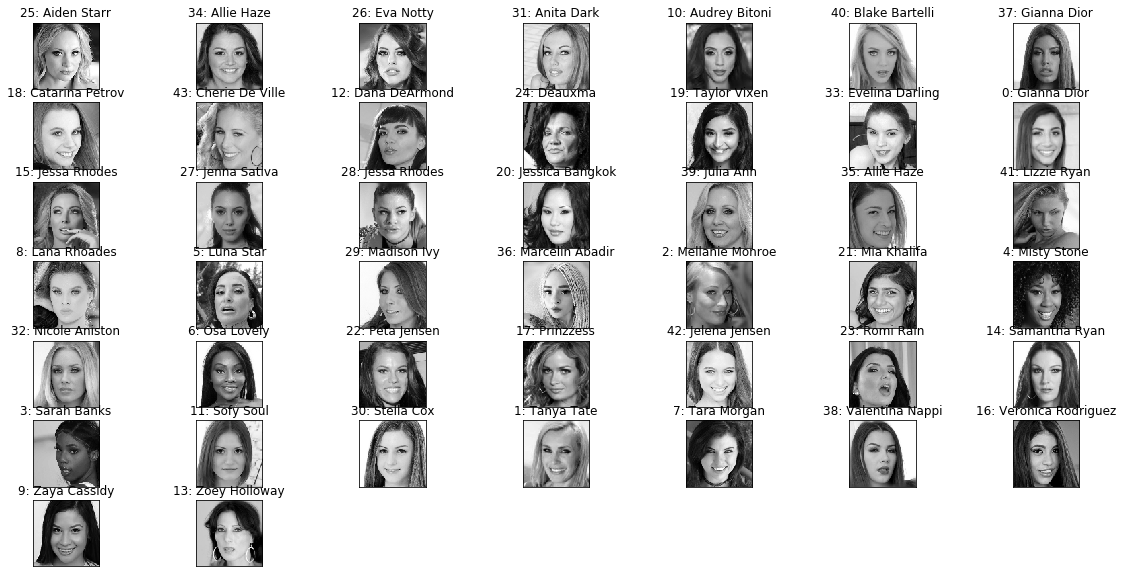

In [29]:
test_data = np.load('test_data.npy', allow_pickle=True)
fig = plt.figure(figsize=(20,10))
results = {cls: [] for cls in LABELS}

# iterate over each image in test_sample
# get the model's class prediction of the image
for num, data in enumerate(test_data):
    data[0] = data[0] / 255.0
    img_data = data[0]
    img_num = data[1]
    y = fig.add_subplot(7, 7, num + 1)
    orig = img_data
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    model_out = MODEL.predict([data]).flatten()
    index = np.argmax(model_out)
    # generate output dictionary
    results = {LABELS[i]: results.get(LABELS[i]) + [model_out[i]] for i in range(NUM_CLASSES)}
    IMAGE_IDs.append(img_num)
    
    # cross-reference the predicted class-index to its class-label (for each test image)
    class_label = CLASS_INDEX.get(index, 'Invalid class!')
    print(f"Image ID: {img_num}\t | Prediction: {class_label}")

    y.imshow(orig, cmap='gray')
    plt.title(f'{img_num}: {class_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('Class Results')

In [30]:
IMAGES_NAMES = [img.split('.')[0] for img in next(os.walk(ALIGNED_TEST_DIR))[2]]

### Tabulated Prediction Probabilities

In [31]:
# Creates a HeatMap using the seaborn library
cm = sns.light_palette("red", as_cmap=True)
df = pd.DataFrame.from_dict(results, orient='index', columns=IMAGE_IDs)
df.style.\
    format("{:.2%}").\
    set_caption('Confidence Values')\
    .background_gradient(cmap=cm)

### Get Top 5 results for Test Image

In [32]:
"""
Re-structures the results dictionary so that each class_label points to another dictionary {k, v}
where k = the Image_Id number and v = the confidence value
"""

def gen_results(results):
    my_dict = {}
    for cls in LABELS:
        probs = iter(results[cls])
        my_dict.update({cls: {}})
        for k in IMAGE_IDs:
            my_dict[cls][int(k)] = next(probs)

    return my_dict

In [33]:
def get_top5(results, ID=1):
    results = gen_results(results)
    probs = np.array([(results[k][ID]) for k in results])
    # print(f'Reverse: {(-probs).argsort()} - {sorted(probs, reverse=True)}')
    indices = (-probs).argsort()[:5] # sorts probabilities (largest - smallest) + returns their corresponding array indices
    top_5 = [CLASS_INDEX.get(i) for i in indices]
    return top_5

In [34]:
Image_ID = 3
TOP_5 = get_top5(results, Image_ID)
TOP_5

['Sarah Banks',
 'Veronica Rodriguez',
 'Audrey Bitoni',
 'Lola Krit',
 'Madison Ivy']

# Get Overall Accuracy

In [35]:
def get_overall_accuracy(results):
    i = 0
    num_correct = 0
    total = len(test_data) # total number of images
    keys = results.keys()
    class_labels = []
    
    for ID in IMAGE_IDs: # loop through each image ID
        predictions = []
        for key in list(keys): # for each model in the results dictionary
            prob = results[key].get(ID)
            predictions.append(prob)
        max_index = np.argmax(predictions) # max index
        label = CLASS_INDEX.get(max_index, 'Invalid class!')
        class_labels.append(label)
    
    for img in os.listdir(ALIGNED_TEST_DIR):
        img = img.split('.')[0].strip() # gets the class name of the image file
        if img == class_labels[i]:
            num_correct += 1
        # print(f"Image name: {img} - predicted label: {class_labels[i]}")
        i += 1 
        
        
    accuracy = round((num_correct / total) * 100, 2)
    return f'{accuracy}%'

# Overall Accuracy

In [36]:
get_overall_accuracy(gen_results(results))

'79.55%'